In [1]:
# Import libraries and set desired options
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import sparse, stats
from scipy.linalg import svd
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from tqdm import tqdm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

/home/nick-skachkov/venv/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%matplotlib inline

plt.style.use('ggplot')

In [3]:
TRAIN_PATH = 'train/'

# Read data sets

In [4]:
X1 = pd.read_csv(TRAIN_PATH + 'X1.csv')
X2 = pd.read_csv(TRAIN_PATH + 'X2.csv')
X3 = pd.read_csv(TRAIN_PATH + 'X3.csv')

Y = pd.read_csv(TRAIN_PATH + 'Y.csv')

In [5]:
TEST_PATH = 'test/'

In [6]:
X1_test = pd.read_csv(TEST_PATH + 'X1.csv')
X2_test = pd.read_csv(TEST_PATH + 'X2.csv')
X3_test = pd.read_csv(TEST_PATH + 'X3.csv')

In [7]:
# X3.to_csv(DATA_PATH + 'X3.csv', index=None)

In [9]:
for column in '45678':
    if column == 'id':
        continue
    col = X1[column].values
    minimum = np.min(col)
    X1[column + '_log'] = np.log(col - minimum + 1)
    X1_test[column + '_log'] = np.log(X1_test[column] - minimum + 1)

In [10]:
for column in X3:
    if column == 'id':
        continue
    col = X3[column].values
    minimum = np.min(col)
    X3[column + '_log'] = np.log(col - minimum + 1)
    X3_test[column + '_log'] = np.log(X3_test[column] - minimum + 1)

In [11]:
for column in X3:
    if column == 'id':
        continue
    col = X3[column]
    mean = col.mean()
    std = np.sqrt(((col - col.mean())**2).mean()) + 1
    X3[column] = (col - mean) / std
    X3_test[column] = (X3_test[column] - mean) / std

In [12]:
for column in '45678':
    if column == 'id':
        continue
    col = X1[column].values
    mean = col.mean()
    std = np.sqrt(((col - col.mean())**2).mean()) + 1
    X1[column] = (col - mean) / std
    X1_test[column] = (X1_test[column] - mean) / std

In [13]:
def transform_categorical_column(X, column):
    for j, unique_value in enumerate(np.unique(X[column].values)):
        X['{}_{}'.format(column, j)] = (X['2'] == unique_value).astype(np.int)

In [14]:
for col in ['2', '3']:
    transform_categorical_column(X1, col)
    transform_categorical_column(X1_test, col)

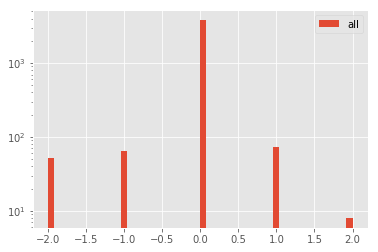

In [15]:
plt.hist(X1['3'], bins=50, label='all', log=True)
plt.legend()
plt.show()

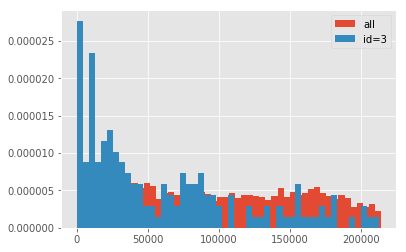

In [16]:
plt.hist(X2.A, bins=50, density=True, label='all')
plt.hist(X2[X2.id == 3].A, bins=50, density=True, label='id=3')
plt.legend()
plt.show()

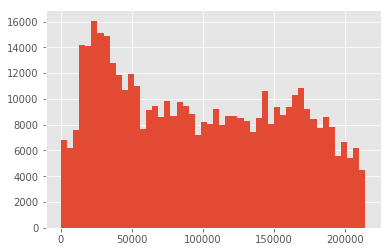

In [17]:
plt.hist(X2.A, bins=50)
plt.show()

In [19]:
Y.head()

,id,1,2,3,4,5
0,3,1,1,0,0,1
1,5,0,1,0,0,0
2,6,0,1,0,0,0
3,8,1,0,0,0,0
4,10,0,0,1,1,0


## Transform X2 using SVD

In [20]:
indexes = np.random.choice(np.arange(len(X2)), size=10000)

In [21]:
len(X2), len(X1), len(X3)

(462888, 4000, 4000)

In [22]:
X2_sample = X2.iloc[indexes]

In [24]:
rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
sparse_matrix = sparse.csr_matrix((np.ones(len(X2)), (row_pos, col_pos)))

In [28]:
def transform_x2(X2, svd=None):
    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
    sparse_matrix = sparse.csr_matrix((np.ones(len(X2)), (row_pos, col_pos)))

    cols_ = sparse_matrix.sum(axis=0)
    rows_ = sparse_matrix.sum(axis=1)

    #sns.distplot(sparse_matrix.sum(axis=0), bins=100)

    if svd is None:
        svd = TruncatedSVD(n_components=1)
        svd.fit(sparse_matrix)

    components = pd.DataFrame(svd.transform(sparse_matrix))
    components['id'] = X2.iloc[:, 0].unique()
    X2 = components
    return X2, svd

## Merge all datasets into one

In [29]:
X2_all = X2.append(X2_test)
X2_all, svd = transform_x2(X2_all)

In [30]:
X_test_id = X1_test.id

In [32]:
X2 = X2_all[X2_all.id.isin(X1.id)]
df = X1.merge(X2, on='id', how='inner').merge(X3, on='id').merge(Y, on='id')
X = df.iloc[:, 1:-5]
Y_cls = df.iloc[:, -5:]

In [33]:
X2 = X2_all[X2_all.id.isin(X1.id)]
df = X1.merge(X3, on='id', how='inner').merge(Y, on='id')
X_nox2 = df.iloc[:, 1:-5]
Y_cls = df.iloc[:, -5:]

In [35]:
X2_test = X2_all[X2_all.id.isin(X1_test.id)]
df_test = X1_test.merge(X2_test, on='id', how='inner').merge(X3_test, on='id')
X_test = df_test.iloc[:, 1:]

In [36]:
X2_test = X2_all[X2_all.id.isin(X1_test.id)]
df_test = X1_test.merge(X3_test, on='id', how='inner')
X_nox2_test = df_test.iloc[:, 1:]

In [37]:
X1_X2 = X1.merge(X2, on='id', how='inner').iloc[:, 1:]
X1_X2_test = X1_test.merge(X2_test, on='id', how='inner').iloc[:, 1:]

# Modeling

In [38]:
def cross_validation_score_statement(estimator,
                                     X,
                                     y,
                                     scoring,
                                     n_splits=5,
                                     statement=None,
                                     random_state=0):
    """
    Evaluate a score by cross-validation. 
    The fit method will be performed on the entire train subset at each iteration,
    the predict method and scoring will be performed only for objects from test subset where statement is True
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit' and 'predict'
        The object to use to fit the data.
    X : pandas.DataFrame
        The data to fit.
    y : pandas.Series
        The target variable to try to predict.
    scoring : callable 
        The scoring function of signature scoring(y_true,y_pred).
    statement : boolean numpy.array of shape equal to y.shape
        The mask showing the objects we want to evaluate estimator on.
    n_splits : int
        Number of folds for cross-validation
    random_state : int
        Random_state for KFold and StratifiedKFold    
    
    Returns
    -----------
    scores : array of float, shape=(n_splits,)
    
    """
    if statement is None:
        cv = KFold(n_splits=n_splits, shuffle=False, random_state=random_state)
        cv_iter = list(cv.split(X, y))
    else:
        cv = StratifiedKFold(n_splits=n_splits,
                             shuffle=True,
                             random_state=random_state)
        cv_iter = list(cv.split(X, statement))
    scores = []

    for train, test in cv_iter:
        estimator.fit(X.iloc[train, :].values, y.iloc[train].values)
        if statement is not None:
            y_statement = y.iloc[test].loc[statement[test]]
            pred_statement = estimator.predict_proba(
                X.iloc[test, :].loc[statement[test]].values)[:, 1]
        else:
            y_statement = y.iloc[test]
            pred_statement = estimator.predict_proba(X.iloc[test, :].values)[:, 1]
        scores.append(scoring(y_statement, pred_statement))
    return np.array(scores)

In [39]:
params = {'1': {'alpha': 0,
  'colsample_bytree': 0.6,
  'eta': 0.05,
  'learning_rate': 0.017,
  'max_delta_step': 5,
  'max_depth': 2,
  'min_child_samples': 100,
  'min_child_weight': 5,
  'n_estimators': 100,
  'num_leaves': 44,
  'scale_pos_weight': 1},
}

### Feature Selection

In [49]:
scores = []
for i in '12345':
    cls = LogisticRegression(C=1.0, penalty='l1')
    cls.fit(X_nox2.values, Y_cls[i].values)
    
    features = (cls.coef_ != 0).ravel()
    cls = LogisticRegression(C=5)
    res = cross_validation_score_statement(X=X_nox2.iloc[:, features], y=Y_cls[i], n_splits=5, random_state=42,
                                           estimator=cls, scoring=roc_auc_score)
    print("ROC_AUC {}: {}".format(i, res.mean()))
    scores.append(res.mean())
print(np.mean(scores))

ROC_AUC 1: 0.6109133991932574
ROC_AUC 2: 0.6108429318462594
ROC_AUC 3: 0.6255292497191289
ROC_AUC 4: 0.6087706481116403
ROC_AUC 5: 0.569781186443849
0.6051674830628271


In [41]:
scores = []
f_imp = []
for i in '12345':
    cls = XGBClassifier(n_jobs=8, random_state=0, **params['1'])
    res = cross_validation_score_statement(X=X, y=Y_cls[i], estimator=cls, scoring=roc_auc_score)
    f_imp.append(cls.feature_importances_)
    print("ROC_AUC {}: {}".format(i, res.mean()))
    scores.append(res.mean())
print(np.mean(scores))

ROC_AUC 1: 0.6009588509471685
ROC_AUC 2: 0.583569031017519
ROC_AUC 3: 0.6122103264780772
ROC_AUC 4: 0.5861806125974078
ROC_AUC 5: 0.5409875780344622
0.584781279814927


In [75]:
X1.head()

,id,1,2,3,4,5,6,7,8,9,...,2_0,2_1,2_2,2_3,2_4,3_0,3_1,3_2,3_3,3_4
0,3,1,-1.0,-1.0,0.012096,0.114546,0.629180,0.030938,-0.401800,0.0,...,0,1,0,0,0,0,1,0,0,0
1,5,0,0.0,0.0,-0.229536,-0.298572,-0.059275,-0.114461,-0.520437,2.0,...,0,0,1,0,0,0,0,1,0,0
2,6,1,0.0,0.0,0.153742,-0.047461,5.669305,-0.082150,0.910618,29.0,...,0,0,1,0,0,0,0,1,0,0
3,8,1,0.0,0.0,-0.001791,0.257112,0.242540,-0.130616,-0.527851,2.0,...,0,0,1,0,0,0,0,1,0,0
4,10,1,0.0,0.0,-0.282306,-0.296951,-0.365036,-0.130616,-0.401800,1.0,...,0,0,1,0,0,0,0,1,0,0


In [78]:
models = []
probas = []
scores = []
for i in tqdm('12345'):
    if i == '1' or True:
        cls = XGBClassifier(n_jobs=8, random_state=0, **params['1'])
        cls.fit(X1.values, Y_cls[i].values)
        proba = cls.predict_proba(X1_test.values)[:, 1]
    else:
        cls = LogisticRegression(C=1.0, penalty='l1')
        cls.fit(X_nox2.values, Y_cls[i].values)
        features = (cls.coef_ != 0).ravel()
        cls = LogisticRegression(C=0.5)
        cls.fit(X_nox2.iloc[:, features].values, Y_cls[i].values)
        proba = cls.predict_proba(X=X_nox2_test.iloc[:, features].values)[:, 1]
    probas += [proba]
    models.append(cls)

100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


In [63]:
scores = []
for i in '12345':
    #cls = XGBClassifier(n_jobs=8, random_state=0, **params['1'])
    cls = LogisticRegression(C=2.0, penalty='l1')
    cls.fit(X.values, Y_cls[i].values)
    #cls = CatBoostClassifier()
    features = (cls.coef_ != 0).ravel()
    cls = LogisticRegression(C=0.5)
    res = cross_validation_score_statement(X=X.iloc[:, features], y=Y_cls[i], n_splits=5, random_state=43,
                                           estimator=cls, scoring=roc_auc_score)
    print("ROC_AUC {}: {}".format(i, res.mean()))
    scores.append(res.mean())
print(np.mean(scores))

ROC_AUC 1: 0.6073019710005298
ROC_AUC 2: 0.6075630666250589
ROC_AUC 3: 0.6171968929700282
ROC_AUC 4: 0.6074882543484363
ROC_AUC 5: 0.5669812061267449
0.6013062782141596


In [65]:
tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X_test_id
baseline[['id', '1', '2', '3', '4', '5']].to_csv('sol10_features_logs.csv', index=False)

# Experiments with Domain Adaptation

In [363]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

In [364]:
random_indexes = np.random.choice(np.arange(4000), size=500)
mask = np.ones(4000, dtype=np.bool)
mask[random_indexes] = False

In [365]:
mask

array([ True,  True,  True, ...,  True,  True,  True])

In [366]:
from torch.optim import Adam, SGD

In [397]:
alpha = 0.1

In [398]:
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * alpha

def grad_reverse(x):
    return GradReverse.apply(x)

In [399]:
class LogReg(nn.Module):
    def __init__(self, inp_size, out=2, hid=100):
        super(LogReg, self).__init__()
        print(inp_size)
        self.layer1 = nn.Sequential(
            nn.Linear(in_features=inp_size, out_features=hid),
            nn.ReLU(),
            nn.Linear(hid, hid),
            nn.ReLU(),
            nn.Linear(hid, hid))
        self.layer2 = nn.Linear(in_features=hid, out_features=out)
        self.adv = nn.Linear(in_features=hid, out_features=1)
        self.bn = nn.BatchNorm1d(inp_size)
    
    def forward(self, X):
        #hid_state = self.layer1(self.bn(X))
        hid_state = self.layer1(self.bn(X))
        return self.layer2(hid_state), self.adv(grad_reverse(hid_state))

In [400]:
model = LogReg(inp_size=X1.values.shape[1], out=5, hid=10)

36


In [409]:
optimizer = SGD(params=model.parameters(), lr=0.01, weight_decay=0.0, momentum=0.8)

In [412]:
for i in range(500):
    bs = 500
    indexes = np.random.choice(np.arange(3500), size=bs)
    test_indexes = np.random.choice(np.arange(len(X1_test)), size=bs)
    optimizer.zero_grad()
    input_tensor = th.Tensor(X1.values[mask])[indexes, :]
    input_test_tensor = th.Tensor(X1_test.values)[test_indexes, :]
    #print(input_tensor.shape)
    logits, adv_logits = model(input_tensor)
    _, adv_test_logits = model(input_test_tensor)
    #print(logits.shape)
    labels = th.Tensor(Y.values[mask])[indexes, 1:]
    loss = F.binary_cross_entropy_with_logits(input=logits, target=labels)
    loss += F.binary_cross_entropy_with_logits(input=adv_logits, target=th.zeros(bs, 1))
    loss += F.binary_cross_entropy_with_logits(input=adv_test_logits, target=th.ones(bs, 1))
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print(float(loss))

2.0038578510284424
2.0027103424072266
1.9978508949279785
1.990417242050171
2.0005130767822266
2.005807399749756
1.9946353435516357
2.0110743045806885
2.00308895111084
1.9955081939697266


In [404]:
logits, adv_logits = model(th.Tensor(X1.values))

0.4811239


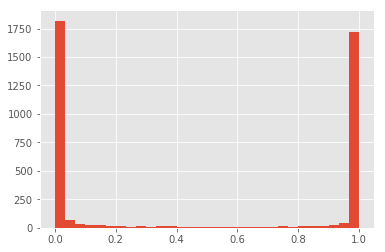

In [301]:
a = th.sigmoid(adv_logits).detach().numpy()
plt.hist(a, bins=30)
print(a.mean())
plt.show()

In [302]:
k = th.sigmoid(adv_logits).detach().numpy().ravel()

In [304]:
(k > 0.5).mean(), (k < 0.5).mean()

(0.47925, 0.52075)

In [305]:
for i in range(5):
    #print(th.sigmoid(logits)[:, i].detach().numpy().shape)
    #print(Y.values[:, i])
    print(roc_auc_score(y_score=th.sigmoid(logits)[:, i].detach().numpy(), y_true=Y.values[:, i+1]))

0.5227268361519309
0.5512660338232774
0.48125328263838957
0.5276869001452378
0.5014335434738025


In [307]:
logits, adv_logits = model(th.Tensor(X1.values[np.logical_not(mask)]))

### results on test

In [308]:
for i in range(5):
    print(roc_auc_score(y_score=th.sigmoid(logits)[:, i].detach().numpy(), y_true=Y.values[np.logical_not(mask), i+1]))

0.5373125326685698
0.5413133523504357
0.4540254737007626
0.4891295546558705
0.5400747508305648


In [105]:
logits, _ = model(th.Tensor(X_test.values))

In [106]:
tmp = pd.DataFrame(th.sigmoid(logits).detach().numpy())

In [107]:
tmp.head()

,0,1,2,3,4
0,0.247434,0.253819,0.283182,0.271962,0.297614
1,0.237261,0.232551,0.424162,0.322065,0.348157
2,0.328054,0.419596,0.255210,0.167643,0.553972
3,0.318084,0.250333,0.412678,0.203318,0.347024
4,0.524603,0.368957,0.410694,0.323245,0.555158


In [108]:
#tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X_test_id
baseline[['id', '1', '2', '3', '4', '5']].to_csv('sol7_adv.csv', index=False)